# Amazon Stock Price Forecasting - using LSTM

In this project, we will use lstm to predict future stock prices of amazon (AMZN)

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn

# Importing Training Dataset
train_data = pd.read_csv('./data/AMZN.csv')
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [2]:
# Importing Testing Dataset
test_data = pd.read_csv('./data/STOCK_US_XNAS_AMZN.csv')
test_data.head()

,Date,Open,High,Low,Close,Volume
0,01/22/2024,156.89,157.05,153.90,154.78,"43,687,473"
1,01/19/2024,153.83,155.76,152.74,155.34,"51,651,633"
2,01/18/2024,152.77,153.78,151.82,153.50,"37,850,246"
3,01/17/2024,151.49,152.15,149.91,151.71,"34,953,359"
4,01/16/2024,153.53,154.99,152.15,153.16,"41,384,641"


# Preprocessing the data.

In cases where stock prices are to be predicted from previous patterns, all that matters is the `date` and `close`.

Therefore, we will only keep `Date` and `Close` columns and drop all the other.

In [3]:
train_data = train_data[['Date', 'Close']]
train_data.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


In [4]:
test_data = test_data[['Date', 'Close']]
test_data.head()

,Date,Close
0,01/22/2024,154.78
1,01/19/2024,155.34
2,01/18/2024,153.50
3,01/17/2024,151.71
4,01/16/2024,153.16


Selecting `GPU` if available for accelerated model training. 

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Converting Date column from `string` datatype into `datetime` datatype

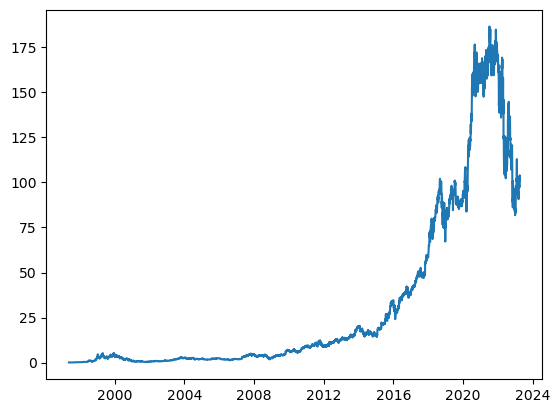

In [6]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

plt.plot(train_data['Date'], train_data['Close'])

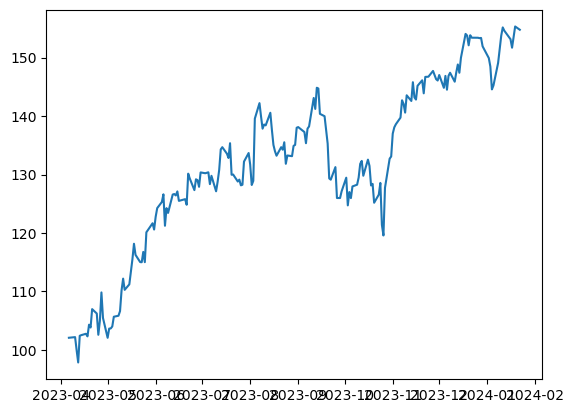

In [7]:
test_data['Date'] = pd.to_datetime(test_data['Date'])

plt.plot(test_data['Date'], test_data['Close'])

Now, as we know we only need `previous close values` and the `date` to predict future values, 
we will simplify the process for us by creating columns for past close values. 

These columns will each hold close values of previous days, upto however many days we want. Let us try and test performance of the model with 7 previous days' worth of values. The model will be trained on these 7 values (`X`) to predict the actual close value (`y`). 

In [8]:
from copy import deepcopy as dc

def prepare_daraframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace = True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace = True)
    
    return df

lookback = 7
train_df = prepare_daraframe_for_lstm(train_data, lookback)
train_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [9]:
test_df = prepare_daraframe_for_lstm(test_data, lookback)
test_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2024-01-10,153.73,155.18,154.62,153.16,151.71,153.50,155.34,154.78
2024-01-09,151.37,153.73,155.18,154.62,153.16,151.71,153.50,155.34
2024-01-08,149.10,151.37,153.73,155.18,154.62,153.16,151.71,153.50
2024-01-05,145.24,149.10,151.37,153.73,155.18,154.62,153.16,151.71
2024-01-04,144.57,145.24,149.10,151.37,153.73,155.18,154.62,153.16


In [10]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_df_as_np = scaler.fit_transform(train_df)

train_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [11]:
test_df_as_np = scaler.fit_transform(test_df)
test_df_as_np

array([[ 0.98790896,  1.        ,  0.98047079, ...,  0.93675889,
         1.        ,  0.97898292],
       [ 0.90398293,  0.9494333 ,  1.        , ...,  0.869377  ,
         0.93094389,  1.        ],
       [ 0.82325747,  0.86713165,  0.9494333 , ...,  0.9239601 ,
         0.86376431,  0.93094389],
       ...,
       [-0.92567568, -1.        , -0.84062772, ..., -0.99058912,
        -0.91555639, -0.93394633],
       [-0.84566145, -0.92711421, -1.        , ..., -0.97402597,
        -0.99061738, -0.91555639],
       [-0.84957326, -0.84864865, -0.92711421, ..., -0.98268398,
        -0.97410396, -0.99061738]])

In [12]:
X_train = train_df_as_np[:, 1:]
X_train = dc(np.flip(X_train, axis = 1))

y_train = train_df_as_np[:, 0]

X_train.shape, y_train.shape

((6509, 7), (6509,))

In [13]:
X_train, y_train

(array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
         -1.        , -0.99995531],
        [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
         -0.99994415, -0.99991063],
        [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
         -0.99989946, -0.99993855],
        ...,
        [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
          0.09308121,  0.10690997],
        [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
          0.10691495,  0.09747299],
        [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
          0.09747802,  0.11398769]]),
 array([-0.99991063, -0.99993855, -0.99995253, ...,  0.09747299,
         0.11398769,  0.08342464]))

In [14]:
X_test = test_df_as_np[:, 1:]
X_test = dc(np.flip(X_test, axis = 1))

y_test = test_df_as_np[:, 0]

X_test.shape, y_test.shape

((192, 7), (192,))

In [15]:
X_test, y_test

(array([[ 0.97898292,  1.        ,  0.93675889, ...,  0.92955536,
          0.98047079,  1.        ],
        [ 1.        ,  0.93094389,  0.869377  , ...,  0.98047079,
          1.        ,  0.9494333 ],
        [ 0.93094389,  0.86376431,  0.9239601 , ...,  1.        ,
          0.9494333 ,  0.86713165],
        ...,
        [-0.93394633, -0.91555639, -0.99058912, ..., -0.83679163,
         -0.84062772, -1.        ],
        [-0.91555639, -0.99061738, -0.97402597, ..., -0.84062772,
         -1.        , -0.92711421],
        [-0.99061738, -0.97410396, -0.98268398, ..., -1.        ,
         -0.92711421, -0.84864865]]),
 array([ 9.87908962e-01,  9.03982930e-01,  8.23257468e-01,  6.85988620e-01,
         6.62162162e-01,  8.00853485e-01,  8.52773826e-01,  9.24253201e-01,
         9.75462304e-01,  9.74039829e-01,  9.76529161e-01,  9.76884780e-01,
         9.91820768e-01,  9.30654339e-01,  9.90042674e-01,  1.00000000e+00,
         8.54196302e-01,  7.63513514e-01,  8.14011380e-01,  7.6564722

We have less data in the testing dataset. Let us split some data from the training dataset and add it to the test dataset.

In [16]:
split_index = int(len(X_train)*0.95)
split_index

6183

In [17]:
X_test_split_from_train = X_train[split_index:]
X_train = X_train[:split_index]

y_test_split_from_train = y_train[split_index:]
y_train = y_train[:split_index]

X_train.shape, X_test_split_from_train.shape, y_train.shape, y_test_split_from_train.shape, X_test_split_from_train, y_test_split_from_train

((6183, 7),
 (326, 7),
 (6183,),
 (326,),
 array([[0.88833832, 0.86703009, 0.84602214, ..., 0.81255847, 0.85785047,
         0.81019275],
        [0.86703009, 0.84602214, 0.81766298, ..., 0.85785047, 0.81019381,
         0.82248768],
        [0.84602214, 0.81766298, 0.81255847, ..., 0.81019381, 0.82248867,
         0.79097548],
        ...,
        [0.05779984, 0.05158   , 0.0506149 , ..., 0.07431453, 0.09308121,
         0.10690997],
        [0.05158   , 0.0506149 , 0.04203581, ..., 0.09308121, 0.10691495,
         0.09747299],
        [0.0506149 , 0.04203581, 0.07431453, ..., 0.10691495, 0.09747802,
         0.11398769]]),
 array([ 0.82248768,  0.79097548,  0.82677192,  0.83342069,  0.83375842,
         0.81875569,  0.82938842,  0.81373165,  0.80776378,  0.78709344,
         0.82663775,  0.79572625,  0.76178508,  0.74995667,  0.74244999,
         0.73099679,  0.77256263,  0.77090044,  0.72808003,  0.73798885,
         0.70345255,  0.67537207,  0.62570442,  0.52892686,  0.54931297,
  

Concating the original test dataset with the cropped train dataset, while ensuring that the dates are sorted in the new test dataset.

In [18]:
X_test = np.insert(X_test, 0, X_test_split_from_train, axis=0)
X_test.shape, X_test

((518, 7),
 array([[ 0.88833832,  0.86703009,  0.84602214, ...,  0.81255847,
          0.85785047,  0.81019275],
        [ 0.86703009,  0.84602214,  0.81766298, ...,  0.85785047,
          0.81019381,  0.82248768],
        [ 0.84602214,  0.81766298,  0.81255847, ...,  0.81019381,
          0.82248867,  0.79097548],
        ...,
        [-0.93394633, -0.91555639, -0.99058912, ..., -0.83679163,
         -0.84062772, -1.        ],
        [-0.91555639, -0.99061738, -0.97402597, ..., -0.84062772,
         -1.        , -0.92711421],
        [-0.99061738, -0.97410396, -0.98268398, ..., -1.        ,
         -0.92711421, -0.84864865]]))

In [19]:
y_test = np.insert(y_test, 0, y_test_split_from_train, axis=0)
y_test.shape, y_test

((518,),
 array([ 8.22487679e-01,  7.90975483e-01,  8.26771923e-01,  8.33420686e-01,
         8.33758423e-01,  8.18755694e-01,  8.29388421e-01,  8.13731653e-01,
         8.07763781e-01,  7.87093438e-01,  8.26637746e-01,  7.95726248e-01,
         7.61785082e-01,  7.49956674e-01,  7.42449990e-01,  7.30996790e-01,
         7.72562635e-01,  7.70900444e-01,  7.28080034e-01,  7.37988846e-01,
         7.03452547e-01,  6.75372068e-01,  6.25704417e-01,  5.28926859e-01,
         5.49312966e-01,  5.00433371e-01,  4.88492395e-01,  4.96696152e-01,
         5.43243153e-01,  6.03248677e-01,  6.20621309e-01,  6.14390799e-01,
         4.88202925e-01,  6.89747429e-01,  6.92921751e-01,  7.30219373e-01,
         7.27817235e-01,  7.04374779e-01,  6.43141521e-01,  6.63232753e-01,
         6.77640190e-01,  6.94691116e-01,  6.57715199e-01,  6.35720575e-01,
         6.09940303e-01,  5.52347717e-01,  6.22385441e-01,  6.48449788e-01,
         6.46031618e-01,  6.20069040e-01,  6.29833208e-01,  5.85286146e-01,
   

In [20]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (518, 7, 1), (6183, 1), (518, 1))

In [21]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([518, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([518, 1]))

In [22]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [23]:
train_dataset

In [24]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeroes(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeroes(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)